Following the tutorial here:

https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html

In [39]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [40]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N-i) for i, xi in enumerate(x)) / (N*sum(x))
    
    return (1 + (1/N) - 2*B)


class MoneyAgent(Agent):
    """An agent with fixed initial wealth"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents"""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.running = True
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = DataCollector(
            model_reporters= {'Gini': compute_gini},
            agent_reporters={'Wealth': 'wealth'}
        )
        
    def step(self):
        """Advance the model by one step"""
        self.datacollector.collect(self)
        self.schedule.step()

In [45]:
fixed_params = {
    'width': 10,
    'height': 10
}

variable_params = {'N': range(10, 500, 10)}

# The variable parameters will be invoked along with the fixed parameters allowing for either or both to be honoured

batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={'Gini': compute_gini}
)

In [46]:
batch_run.run_all()

245it [02:21,  1.74it/s]


In [47]:
run_data = batch_run.get_model_vars_dataframe()

In [52]:
batch_run?

In [32]:
model = MoneyModel(50,10,10)
for i in range(100):
    model.step()

In [33]:
%matplotlib inline

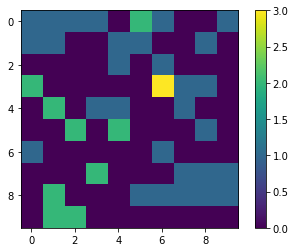

In [34]:
agent_counts = np.zeros((model.grid.width, model.grid.height))

for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

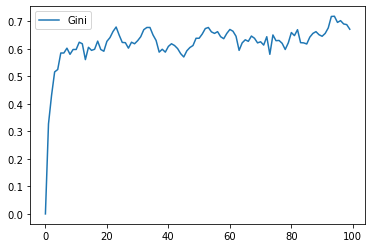

In [35]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [36]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()

In [37]:
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

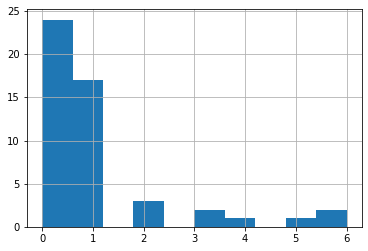

In [38]:
end_wealth = agent_wealth.xs(99, level='Step')['Wealth']
end_wealth.hist()